Potential TODO:
- Prediction Website


- Work on refining best models
- Visualising some predictions
- Visualising feature importance for the models

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [19]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [20]:
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   login                    5725 non-null   int64  
 1   country                  5725 non-null   object 
 2   account_currency         5725 non-null   object 
 3   Trading_Frequency        5725 non-null   float64
 4   Total_Trades             5725 non-null   int64  
 5   Buy_Percentage           5725 non-null   float64
 6   Average_Volume           5725 non-null   float64
 7   Average_Volume_USD       5725 non-null   float64
 8   Average_DPM              5725 non-null   float64
 9   Unique_Symbols_Traded    5725 non-null   int64  
 10  Peak_Trading_Times       5725 non-null   int64  
 11  Ratio_Profitable_Trades  5725 non-null   float64
 12  Profit_Loss_Variability  5725 non-null   float64
 13  Average_Trade_Duration   5725 non-null   float64
 14  TP/SL Hit Ratio         

In [21]:
modelling_df.describe()

,login,Trading_Frequency,Total_Trades,Buy_Percentage,Average_Volume,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,Peak_Trading_Times,Ratio_Profitable_Trades,...,Average_Trade_Duration,TP/SL Hit Ratio,Reward_Risk_Ratio,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,average_credit,longevity,longevity_bin
count,5.725000e+03,5725.000000,5725.000000,5725.000000,5725.000000,5.725000e+03,5725.000000,5725.000000,5725.000000,5725.000000,...,5.725000e+03,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000,5725.000000
mean,4.260059e+06,24.677048,242.507424,44.600729,0.386369,2.283864e+08,-145.503040,5.700262,13.522445,0.472580,...,6.628252e+04,1.763087,1.714086,-0.410879,0.184834,-9.806129,15.091317,57.041656,45.232664,0.631790
std,1.654573e+07,710.948151,1023.377574,28.085715,1.621218,1.838682e+09,3692.263888,6.881594,4.689827,0.283212,...,2.094645e+05,27.804664,223.521743,3.629525,31.930857,720.966109,103.767705,242.761659,70.013825,1.011621
min,5.249780e+05,0.010178,1.000000,0.000000,0.005000,1.040000e+00,-109247.458671,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000,-8311.305640,-108.598893,-1173.062580,-38585.491238,-2423.933085,0.000000,0.000000,0.000000
25%,8.148130e+05,1.000000,8.000000,26.402189,0.028333,2.613592e+04,-467.261699,1.000000,10.000000,0.285714,...,4.441059e+03,0.000000,0.000000,0.000000,-0.060256,-16.592206,0.303777,0.000000,2.000000,0.000000
50%,8.215830e+05,2.486111,33.000000,46.650718,0.078333,3.663738e+05,-71.891849,3.000000,15.000000,0.500000,...,1.570000e+04,0.000000,0.000000,0.000000,0.000000,-1.781250,2.597403,0.000000,15.000000,0.000000
75%,7.056823e+06,7.000000,142.000000,60.000000,0.270000,2.200197e+07,44.698309,7.000000,17.000000,0.666667,...,5.841114e+04,0.090909,0.199083,0.000000,0.000486,0.220833,8.539722,2.000000,60.000000,1.000000
max,1.000055e+09,46509.000000,46509.000000,100.000000,39.285714,6.827463e+10,112017.955519,65.000000,23.000000,1.000000,...,6.793694e+06,1245.000000,9557.708333,0.000000,1045.468282,15005.000000,3721.574881,8000.000000,415.000000,5.000000


In [22]:
# Convert 'country', 'account_currency', and 'Trading_Method' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')

# Convert 'active' column to categorical
modelling_df['active'] = modelling_df['active'].astype('category')

## Correlation Analysis

In [23]:
numeric_cols = modelling_df.select_dtypes(include=['int64', 'float64']).columns

# Creating a new DataFrame with only numeric columns
df_numeric = modelling_df[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

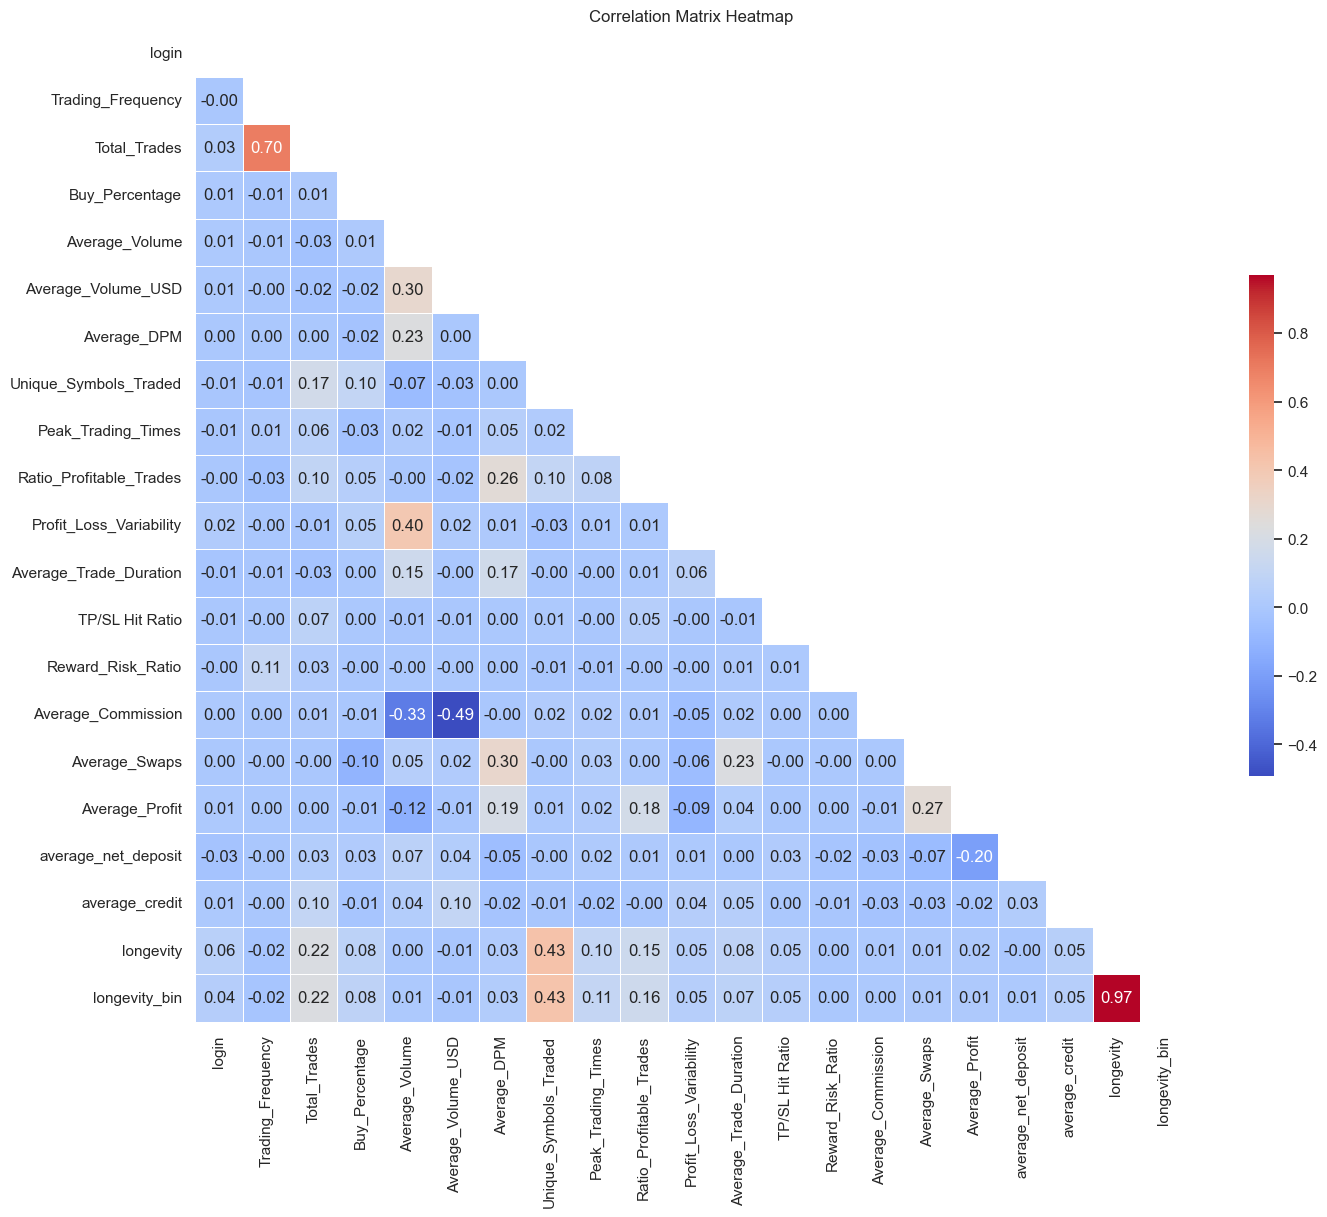

In [24]:
# Setting up the aesthetics for the heatmap
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 13))

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                      square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

## Modelling Preprocessing

In [25]:
# Remove specified columns and set 'longevity' as the target variable
features_df = modelling_df.drop(columns=['login', 'active', 'Unique_Symbols_Traded', 'Average_Volume', 'longevity', 'longevity_bin'])
y = modelling_df['longevity']

In [26]:
# List of all numeric columns
all_numeric_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(features_df)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

## Model Splitting

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 4007
Test Set Size: 859
Validation Set Size: 859


## Model Comparison

In [28]:
# Define regression models
regression_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror'),  
    "Neural Network Regressor": MLPRegressor(max_iter=10000),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR()
}

Decision Tree Regressor - Validation Metrics:
Mean Absolute Error (MAE): 7.6508
Mean Squared Error (MSE): 497.5320
Root Mean Squared Error (RMSE): 22.3054
R-squared (R2): 0.9137

Decision Tree Regressor - Testing Metrics:
Mean Absolute Error (MAE): 7.4540
Mean Squared Error (MSE): 501.2934
Root Mean Squared Error (RMSE): 22.3896
R-squared (R2): 0.9016



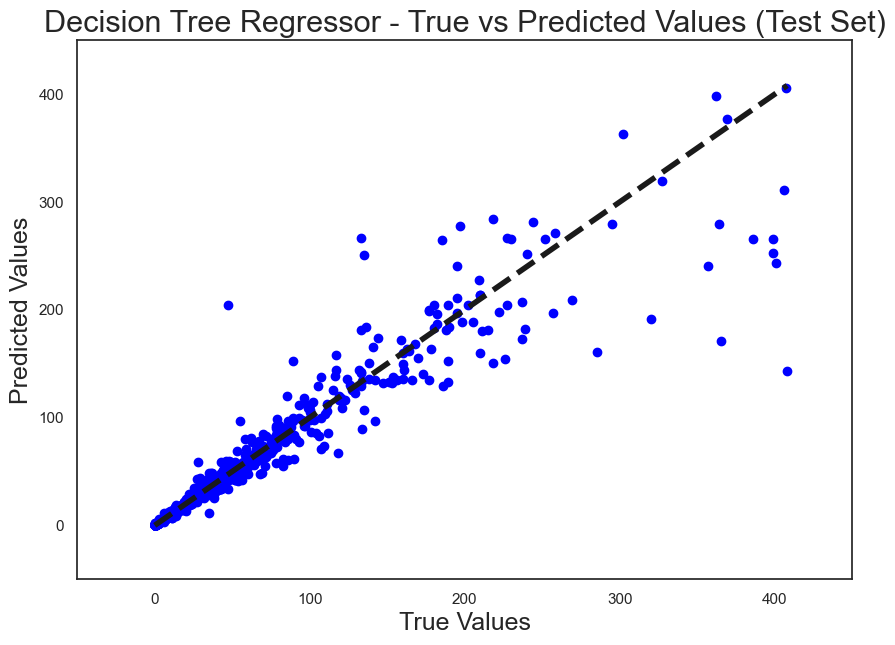

Random Forest Regressor - Validation Metrics:
Mean Absolute Error (MAE): 4.5012
Mean Squared Error (MSE): 256.0300
Root Mean Squared Error (RMSE): 16.0009
R-squared (R2): 0.9556

Random Forest Regressor - Testing Metrics:
Mean Absolute Error (MAE): 3.8192
Mean Squared Error (MSE): 198.1964
Root Mean Squared Error (RMSE): 14.0782
R-squared (R2): 0.9611



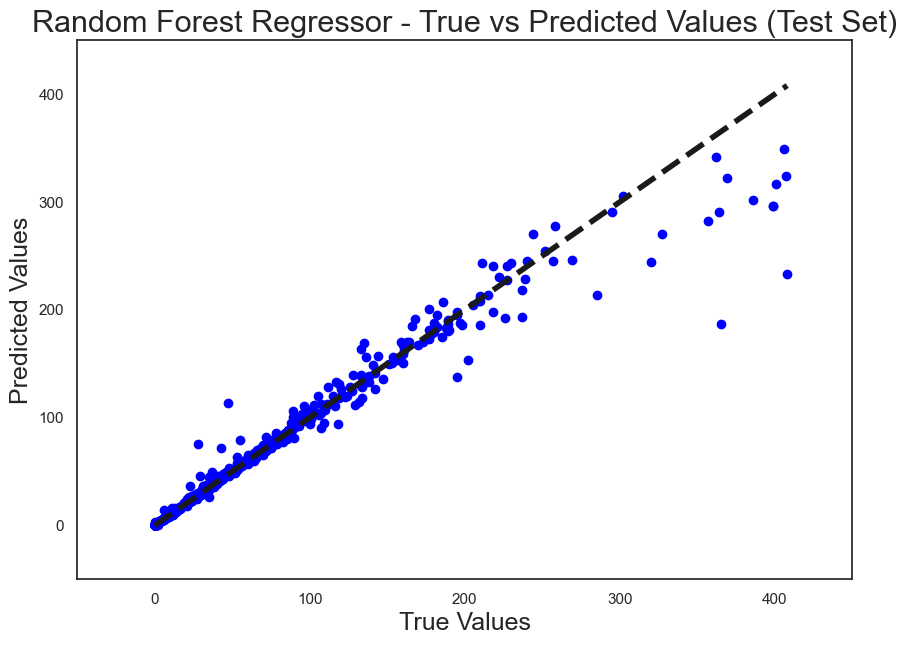

XGBoost Regressor - Validation Metrics:
Mean Absolute Error (MAE): 4.8520
Mean Squared Error (MSE): 166.4971
Root Mean Squared Error (RMSE): 12.9034
R-squared (R2): 0.9711

XGBoost Regressor - Testing Metrics:
Mean Absolute Error (MAE): 4.2892
Mean Squared Error (MSE): 120.7995
Root Mean Squared Error (RMSE): 10.9909
R-squared (R2): 0.9763



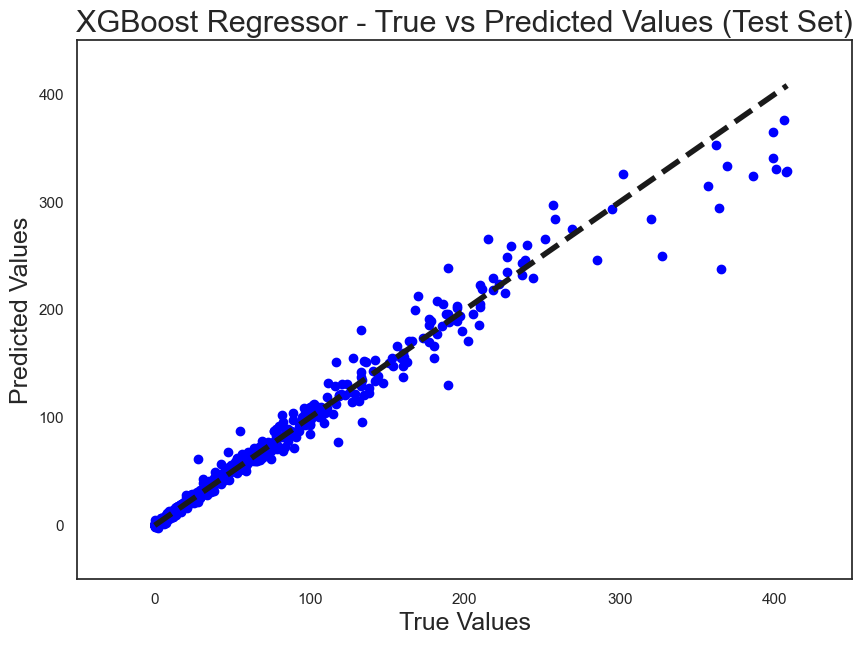

Neural Network Regressor - Validation Metrics:
Mean Absolute Error (MAE): 40.1465
Mean Squared Error (MSE): 5492.7697
Root Mean Squared Error (RMSE): 74.1132
R-squared (R2): 0.0472

Neural Network Regressor - Testing Metrics:
Mean Absolute Error (MAE): 36.1382
Mean Squared Error (MSE): 3750.3947
Root Mean Squared Error (RMSE): 61.2405
R-squared (R2): 0.2641



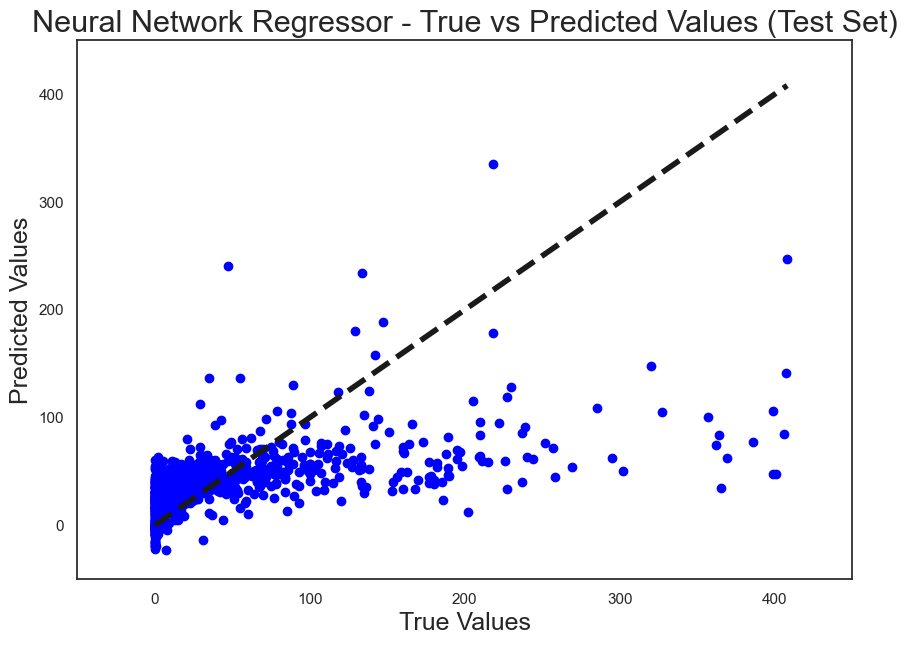

Linear Regression - Validation Metrics:
Mean Absolute Error (MAE): 43.5851
Mean Squared Error (MSE): 4691.4677
Root Mean Squared Error (RMSE): 68.4943
R-squared (R2): 0.1862

Linear Regression - Testing Metrics:
Mean Absolute Error (MAE): 41.1426
Mean Squared Error (MSE): 4055.7865
Root Mean Squared Error (RMSE): 63.6851
R-squared (R2): 0.2042



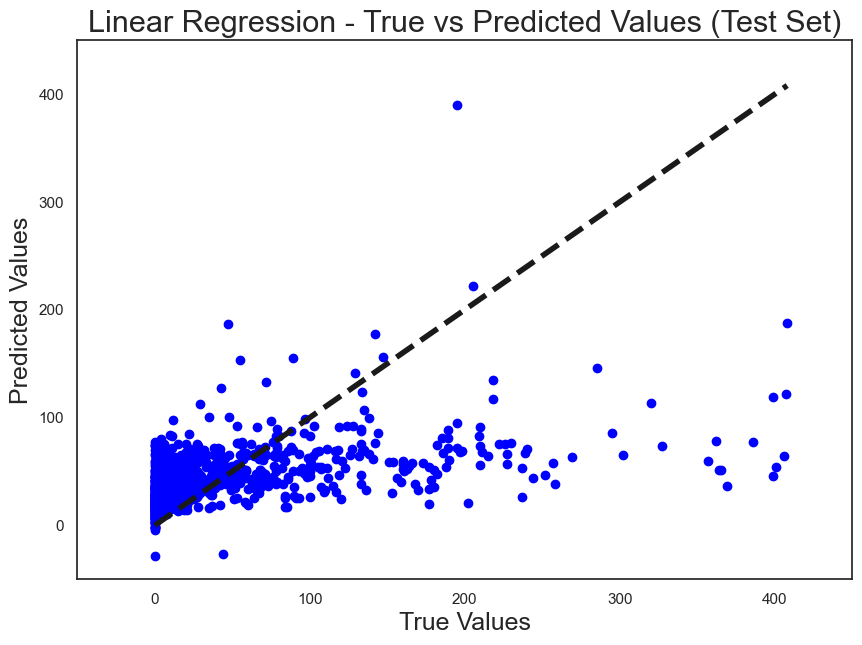

Ridge Regression - Validation Metrics:
Mean Absolute Error (MAE): 43.5857
Mean Squared Error (MSE): 4691.4775
Root Mean Squared Error (RMSE): 68.4944
R-squared (R2): 0.1862

Ridge Regression - Testing Metrics:
Mean Absolute Error (MAE): 41.1430
Mean Squared Error (MSE): 4055.7212
Root Mean Squared Error (RMSE): 63.6845
R-squared (R2): 0.2042



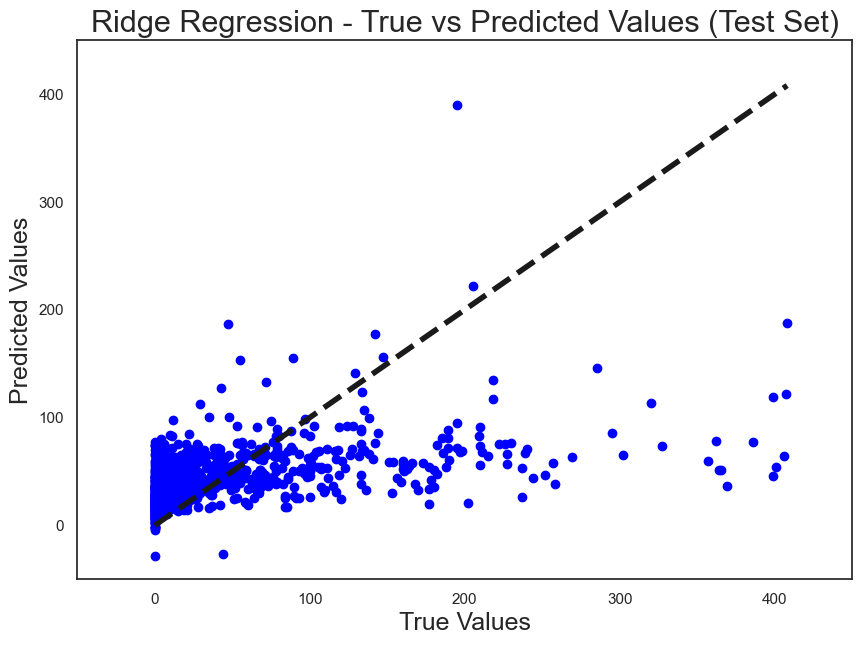

Lasso Regression - Validation Metrics:
Mean Absolute Error (MAE): 43.9600
Mean Squared Error (MSE): 4708.7404
Root Mean Squared Error (RMSE): 68.6203
R-squared (R2): 0.1832

Lasso Regression - Testing Metrics:
Mean Absolute Error (MAE): 41.4198
Mean Squared Error (MSE): 4065.0304
Root Mean Squared Error (RMSE): 63.7576
R-squared (R2): 0.2024



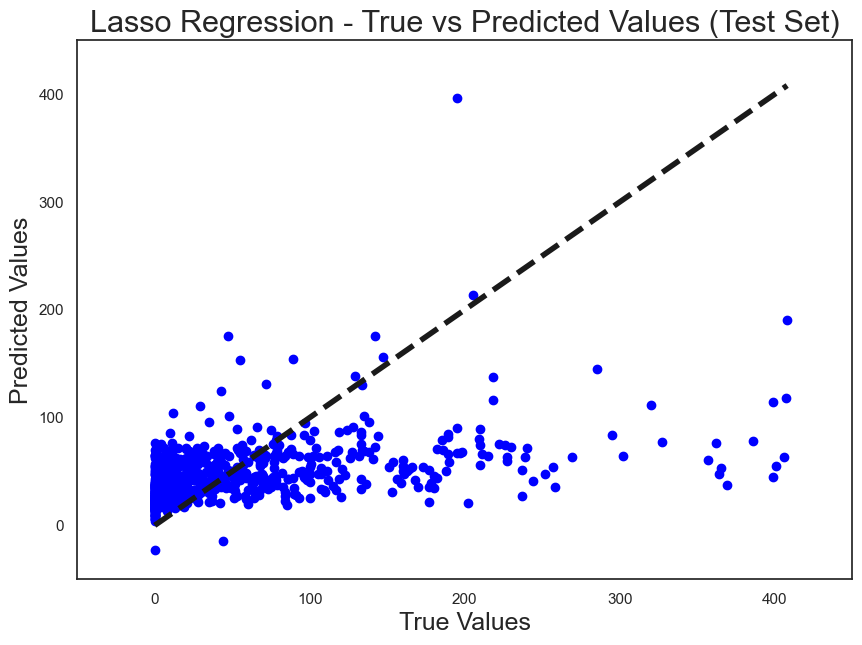

KNeighbors Regressor - Validation Metrics:
Mean Absolute Error (MAE): 37.8542
Mean Squared Error (MSE): 4600.5404
Root Mean Squared Error (RMSE): 67.8273
R-squared (R2): 0.2020

KNeighbors Regressor - Testing Metrics:
Mean Absolute Error (MAE): 35.2766
Mean Squared Error (MSE): 3714.2569
Root Mean Squared Error (RMSE): 60.9447
R-squared (R2): 0.2712



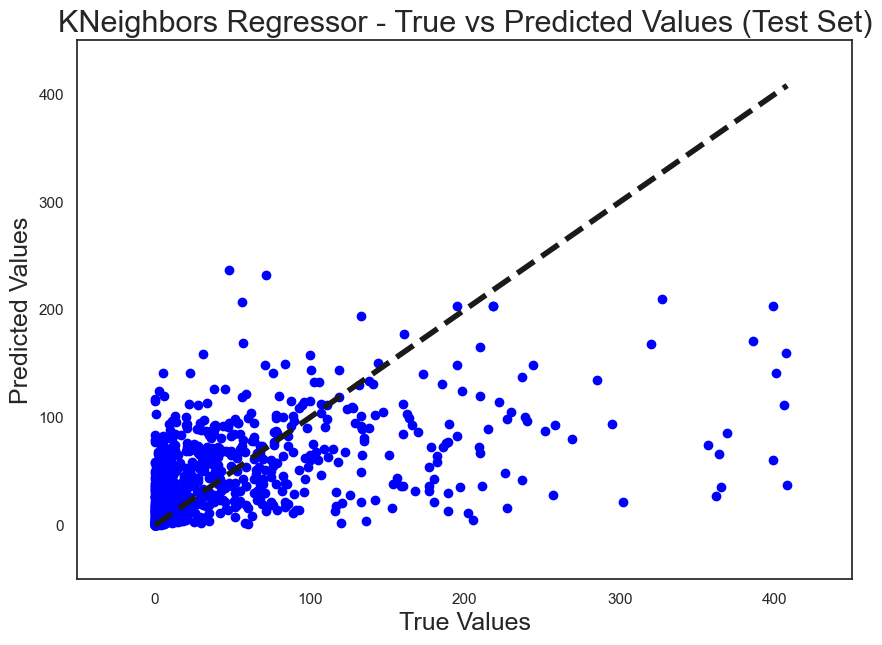

Support Vector Regressor - Validation Metrics:
Mean Absolute Error (MAE): 44.8494
Mean Squared Error (MSE): 6829.5527
Root Mean Squared Error (RMSE): 82.6411
R-squared (R2): -0.1846

Support Vector Regressor - Testing Metrics:
Mean Absolute Error (MAE): 41.5872
Mean Squared Error (MSE): 5934.8958
Root Mean Squared Error (RMSE): 77.0383
R-squared (R2): -0.1645



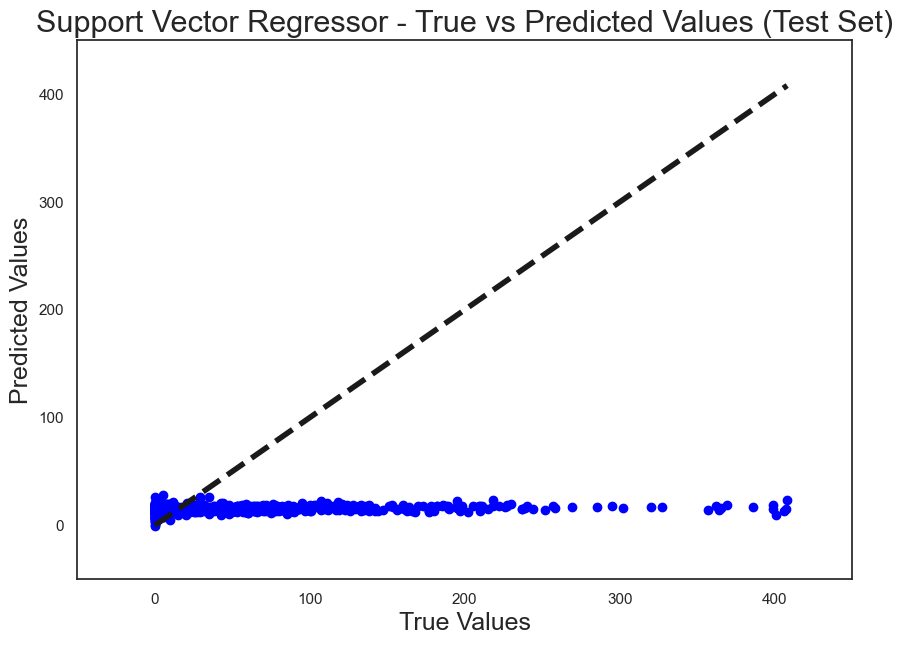

In [34]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name}")
    # Train the model on the training set
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)

    # Calculate evaluation metrics on validation set
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val, y_val_pred)

    print(f"Validation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_val:.4f}")
    print(f"Mean Squared Error (MSE): {mse_val:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_val:.4f}")
    print(f"R-squared (R2): {r2_val:.4f}")
    print()

    # Now proceed to evaluate on the test set

    # Make predictions on the test set
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics on test set
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"Testing Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
    print(f"Mean Squared Error (MSE): {mse_test:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
    print(f"R-squared (R2): {r2_test:.4f}")
    print()


    # Plotting true vs predicted values for test set
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(y_test, y_test_pred, color='blue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
    ax.set_xlim([-50, 450])
    ax.set_ylim([-50, 450])
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=18)
    ax.set_title(f'{name} - True vs Predicted Values (Test Set)', fontsize=22)

    plt.show()